In [1]:
%matplotlib inline

# General packages for system, time, etc
import os, time, csv
import datetime
from datetime import date
import glob
import feather  # for compiling files

# scitnific computing and plotting
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

# HDDM related packages
import pymc as pm
import hddm
import kabuki
import arviz as az
print("The current HDDM version is: ", hddm.__version__)
print("The current PyMC version is: ", pm.__version__)
print("The current ArviZ version is: ", az.__version__)

# parallel processing related
from p_tqdm import p_map
from functools import partial

# set the color of plots
from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color='bgrcmykw')

/opt/conda/lib/python3.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


The current HDDM version is:  0.8.0
The current PyMC version is:  2.3.8
The current ArviZ version is:  0.11.4


In [2]:
data = hddm.load_csv('/opt/conda/lib/python3.7/site-packages/hddm/examples/cavanagh_theta_nn.csv')
data.tail()

subj_idx stim     rt  response     theta  dbs conf
3983        13   LL  1.450       0.0 -1.237166    0   HC
3984        13   WL  0.711       1.0 -0.377450    0   LC
3985        13   WL  0.784       1.0 -0.694194    0   LC
3986        13   LL  2.350       0.0 -0.546536    0   HC
3987        13   WW  1.250       1.0  0.752388    0   HC

In [3]:
samples = 25000  # Cavanagh used 30,000 and 10, 000 burn.
burn = 10000     
nppc = 1000     # 1000 samples for posterior predictive, super slow
thin = 3
chains = 4
test_mode = True

In [4]:
# M7: Regression for both parameters
def run_m7(id, df=None, samples=None, burn=None, save_name="ms7"): 
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id
    a_reg = {'model': "a ~ theta:C(conf, Treatment('LC')):C(dbs, Treatment('0'))", 'link_func': lambda x: x}
    v_reg = {'model': "v ~ C(conf, Treatment('LC'))", 'link_func': lambda x: x}
    reg_descr = [a_reg, v_reg]
    
    m = hddm.HDDMRegressor(df,
                           reg_descr,
                           group_only_regressors=False,
                           keep_regressor_trace=True,
                           include=['z', 'sv', 'st', 'sz'])
    m.find_starting_values()
    m.sample(samples, burn=burn, dbname=dbname, db='pickle') # it's neccessary to save the model data
    m.save(mname)
    
    return m

In [5]:
%%time
file_path = "/home/jovyan/hddm/temp/"

if test_mode:
    model_func = [run_m7]
    
    m_keys = ["ms7"]
    
    models = {"ms7": []}
    
else: 
    model_func = [run_m0, run_m1, run_m2, run_m3, 
                  run_m4, run_m5, run_m6, run_m7]

    m_keys = ["ms0", "ms1", "ms2",
              "ms3", "ms4", "ms5",
              "ms6", "ms7"]
        
    models = {"ms0": [], "ms1": [], "ms2": [], 
              "ms3": [], "ms4": [], "ms5": [], 
              "ms6": [], "ms7": []}

for ii in range(len(model_func)):
    file_full_path = file_path + "/" + m_keys[ii] + "_tmp1_chain_*[!db]" 
    # print(file_full_path)
    file_names = glob.glob(file_full_path, recursive=False)
    print(file_names)
    
    if file_names:
        for jj in file_names:
            print('current loading: ', jj, '\n')
            models[m_keys[ii]].append(hddm.load(jj))
    else:
        print('current estimating:', m_keys[ii])
        models[m_keys[ii]] = p_map(partial(model_func[ii], df=data, samples=samples, 
                                         burn=burn),
                                 range(chains))

['/home/jovyan/hddm/temp/ms7_tmp1_chain_3', '/home/jovyan/hddm/temp/ms7_tmp1_chain_2', '/home/jovyan/hddm/temp/ms7_tmp1_chain_0', '/home/jovyan/hddm/temp/ms7_tmp1_chain_1']
current loading:  /home/jovyan/hddm/temp/ms7_tmp1_chain_3 

current loading:  /home/jovyan/hddm/temp/ms7_tmp1_chain_2 

current loading:  /home/jovyan/hddm/temp/ms7_tmp1_chain_0 

current loading:  /home/jovyan/hddm/temp/ms7_tmp1_chain_1 

CPU times: user 27.9 s, sys: 700 ms, total: 28.6 s
Wall time: 29.2 s


In [6]:
%%time

## step 2: Get posterior trace

if test_mode:
    df_traces = {"ms7": []}
else:
    df_traces = {"ms0": [], "ms1": [], "ms2": [], 
                 "ms3": [], "ms4": [], "ms5": [],
                 "ms6": [], "ms7": []}

for key, model in models.items():
#    ms = models[m_keys[ii]]
    print(key)
    trace_tmp = []
    for jj in range(len(model)):
        trace_tmp = model[jj].get_traces()
        trace_tmp['chain'] = jj
        trace_tmp['draw'] = np.arange(len(trace_tmp), dtype=int)
        df_traces[key].append(trace_tmp)
    df_traces[key] = pd.concat(df_traces[key])

ms7
CPU times: user 28.4 ms, sys: 16 µs, total: 28.4 ms
Wall time: 27.6 ms


In [7]:
from p_tqdm import p_map
from functools import partial

# NOTE: I hacked the `post_pred_gen`, 
# more detals: https://groups.google.com/g/hddm-users/c/Is6AM7eN0fo
from post_pred_gen_redifined import _parents_to_random_posterior_sample
from post_pred_gen_redifined import _post_pred_generate
from post_pred_gen_redifined import post_pred_gen

from pointwise_loglik_gen import _pointwise_like_generate
from pointwise_loglik_gen import pointwise_like_gen

In [8]:
%%time

if test_mode:
    df_ppc   = {"ms7": []}
else:  
    df_ppc = {"ms0": [], "ms1": [], "ms2": [], 
              "ms3": [], "ms4": [], "ms5": [], 
              "ms6": [], "ms7": []}

for ii in range(len(m_keys)):
    key = m_keys[ii]
    value = df_ppc[m_keys[ii]]
    
    if not bool(value):
        print("No PPC values, try to get feather file names")
        # read ftr filenames
        ftr_path = file_path + "df_" + key + "_tmp1_ppc_chain_*ftr" 
        ftr_names = glob.glob(ftr_path, recursive=False)
        
        # if there are ftr files
        if ftr_names:
            print("Got feather file names, loading the PPC")
            for ftrname in ftr_names:
#             for f_id in range(len(ftr_names)):
                print("loading \n", ftrname)
                df_tmp = pd.read_feather(ftrname, columns=None, use_threads=True)
                df_tmp = df_tmp.set_index(["node", "draw", 'trial_idx'])
                df_ppc[key].append(df_tmp)     
        else:
            print("No feather files either, run PPC now ...")
#             for ii in range(len(m_keys)):
            ms = models[m_keys[ii]]
            print("Generating PPC ", key, "for", m_keys[ii])
            start_time = time.time()  # the start time of the processing
        #     df_ppc[m_keys[ii]] = p_map(partial(post_pred_gen, samples = 500), ms)
            df_ppc[key] = p_map(partial(post_pred_gen), ms)

            print("Running PPC costs %f seconds" % (time.time() - start_time))
            
            print("Save PPC to feather files")
            for chain in range(len(df_ppc[key])):
                ftrname = file_path + "df_" + key + "_ppc_chain_" + str(chain) + ".ftr"
                print(ftrname)
                df_ppc[key][chain].reset_index().to_feather(ftrname)
    else:
        continue

No PPC values, try to get feather file names
Got feather file names, loading the PPC
loading 
 /home/jovyan/hddm/temp/df_ms7_tmp1_ppc_chain_3.ftr
loading 
 /home/jovyan/hddm/temp/df_ms7_tmp1_ppc_chain_1.ftr
loading 
 /home/jovyan/hddm/temp/df_ms7_tmp1_ppc_chain_2.ftr
loading 
 /home/jovyan/hddm/temp/df_ms7_tmp1_ppc_chain_0.ftr
CPU times: user 1.5 s, sys: 503 ms, total: 2 s
Wall time: 1.6 s


In [9]:
%%time

## total time: 2h 38min 51s when test_mode is False
if test_mode:

    df_pll = {"ms7": []} 
    
else:
    df_pll = {"ms0": [], "ms1": [], "ms2": [], 
              "ms3": [], "ms4": [], "ms5": [], 
              "ms6": [], "ms7": []}  
for ii in range(len(m_keys)):
    key = m_keys[ii]
    value = df_pll[m_keys[ii]]

    if not bool(value):
        print("\nNo loglik values, try to get feather file names")
        # read ftr filenames
        ftr_path = file_path + "df_" + key + "_tmp1_pll_chain_*ftr" 
        ftr_names = glob.glob(ftr_path, recursive=False)
        # print(ftr_names)
        
        # if there are ftr files
        if ftr_names:
            print("Got feather file names, loading the loglik files")
            for ftrname in ftr_names:
                print("loading \n", ftrname)
                df_tmp = pd.read_feather(ftrname, columns=None, use_threads=True)
                df_tmp = df_tmp.set_index(["node", "draw", 'trial_idx'])
                df_pll[key].append(df_tmp)
        else:
            print("No feather files either, run loglik now ...")

            ms = models[m_keys[ii]]
            print("Generating loglik ", key, "for", m_keys[ii])
            start_time = time.time()  # the start time of the processing
            # df_pll[m_keys[ii]] = p_map(partial(pointwise_like_gen, samples = 500), ms)
            df_pll[key] = p_map(partial(pointwise_like_gen), ms)

            print("Generating loglik costs %f seconds" % (time.time() - start_time))
            
            print("Save loglik to feather files")
            for chain in range(len(df_pll[key])):
                ftrname = file_path + "df_" + key + "_tmp1_pll_chain_" + str(chain) + ".ftr"
                print(ftrname)
                df_pll[key][chain].reset_index().to_feather(ftrname)
    else:
        continue


No loglik values, try to get feather file names
Got feather file names, loading the loglik files
loading 
 /home/jovyan/hddm/temp/df_ms7_tmp1_pll_chain_0.ftr
loading 
 /home/jovyan/hddm/temp/df_ms7_tmp1_pll_chain_1.ftr
loading 
 /home/jovyan/hddm/temp/df_ms7_tmp1_pll_chain_3.ftr
loading 
 /home/jovyan/hddm/temp/df_ms7_tmp1_pll_chain_2.ftr
CPU times: user 6.46 s, sys: 3.91 s, total: 10.4 s
Wall time: 8.7 s


In [10]:
%%time

if test_mode:
    InfData = {"ms7": []} 
    
else:
    InfData = {"ms0": [], "ms1": [], "ms2": [], 
              "ms3": [], "ms4": [], "ms5": [], 
              "ms6": [], "ms7": []}  

for ii in range(len(models)):
    obs_data = models[m_keys[ii]][0].data.copy()
    obs_data.index.names = ['trial_idx']
    if 'conf' in obs_data.columns:
        obs_data.drop(['subj_idx','stim', 'theta','dbs','conf'], axis=1, inplace=True)
    xdata_observed = xr.Dataset.from_dataframe(obs_data)

    df_traces_tmp = df_traces[m_keys[ii]].set_index(["chain", "draw"])
    xdata_posterior = xr.Dataset.from_dataframe(df_traces_tmp)
    
    df_ppc_tmp = pd.concat(df_ppc[m_keys[ii]], names=['chain'], 
                            keys = list(range(len(df_ppc[m_keys[ii]]))))
#     df_ppc_tmp['response'] = df_ppc_tmp['response'].astype('float')
    df_ppc_tmp = df_ppc_tmp.reset_index(level=1, drop=True)
    xdata_post_pred = xr.Dataset.from_dataframe(df_ppc_tmp)
    
    df_pll_tmp = pd.concat(df_pll[m_keys[ii]], names=['chain'], 
                            keys = list(range(len(df_pll[m_keys[ii]]))))
    df_pll_tmp = df_pll_tmp.reset_index(level=1, drop=True)
    xdata_loglik = xr.Dataset.from_dataframe(df_pll_tmp)
    
    InfData[m_keys[ii]] = az.InferenceData(posterior=xdata_posterior, 
                                             observed_data=xdata_observed,
                                             posterior_predictive=xdata_post_pred,
                                             log_likelihood = xdata_loglik)

CPU times: user 14.6 s, sys: 5.43 s, total: 20.1 s
Wall time: 20.1 s


Here, `xarray_var_iter()` is used to select the data for plotting, `xarray_var_iter()` in turn used `xarray_sel_iter()` to select the data.

Input of `xarray_sel_iter()` are `inferencedata`, `var_names`, `combine`, `skip_dims`. The `skip_dims` are those in the observed dimensions.


By using this function, the variable name and its data will be selected, and `yield` a tuple which contain the variable name, two empty dict and a "numpy.ndarray" for observed_data.

For posterior_predicitves, it will yield a tuple which contain the variable name, two empty dict and a "numpy.ndarray" with a length of 4, each contain 1000 data points, represents samples from 4 chains.

The returned list (which includes "rt" and "repsonse") in HDDM case will be used as input of plotter.

`obs_plotters`: A list of 2 elements, a tuple, corresponding to number of `var_names`. In our cases, it has two tuples, one for RT, one for response. In the first tuple, it has 4 elements: var_name, two empty dict (one for `selection`, one for `isel`), and one np.ndarray (with length of selected obs).

`selection`, `isel`, are used for labelling in plotting (arviz/plots/backends/matplotlib/ppcplot.py L358) `labeller.make_pp_label(var_name, pp_var_name, selection, isel), fontsize=ax_labelsize)`. After teseting, I found that only when both `selection` and `isel` are filled, there will it will be added at x-axis in the plot.

```
def make_pp_label(self, var_name, pp_var_name, sel, isel):
    """WIP."""
    names = self.var_pp_to_str(var_name, pp_var_name)
    return self.make_label_vert(names, sel, isel)
```

`pp_plotters`: A list of 2 elements two, a tuple, corresponding to number of `var_names`. In our cases, it has two tuples, one for RT, one for response. In the first tuple, it has 4 elements: var_name, two empty dict, and one np.ndarray (with length of **chains**). In the forth elements of the two tuples, it contain four chains of data of the Posterior predictives. 

**Can we hack it here, include longer list?**

Here is an example script for plotting prior and posterior together:
https://github.com/percygautam/arviz-examples/blob/master/Prior_Posterior_plot.ipynb

[3, 'HC', 1]
[3, 'LC', 1]
[3, 'LC', 0]
[3, 'HC', 0]
[7, 'HC', 1]
[7, 'LC', 1]
[7, 'LC', 0]
[7, 'HC', 0]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc0a9db6d90>,
      dtype=object)

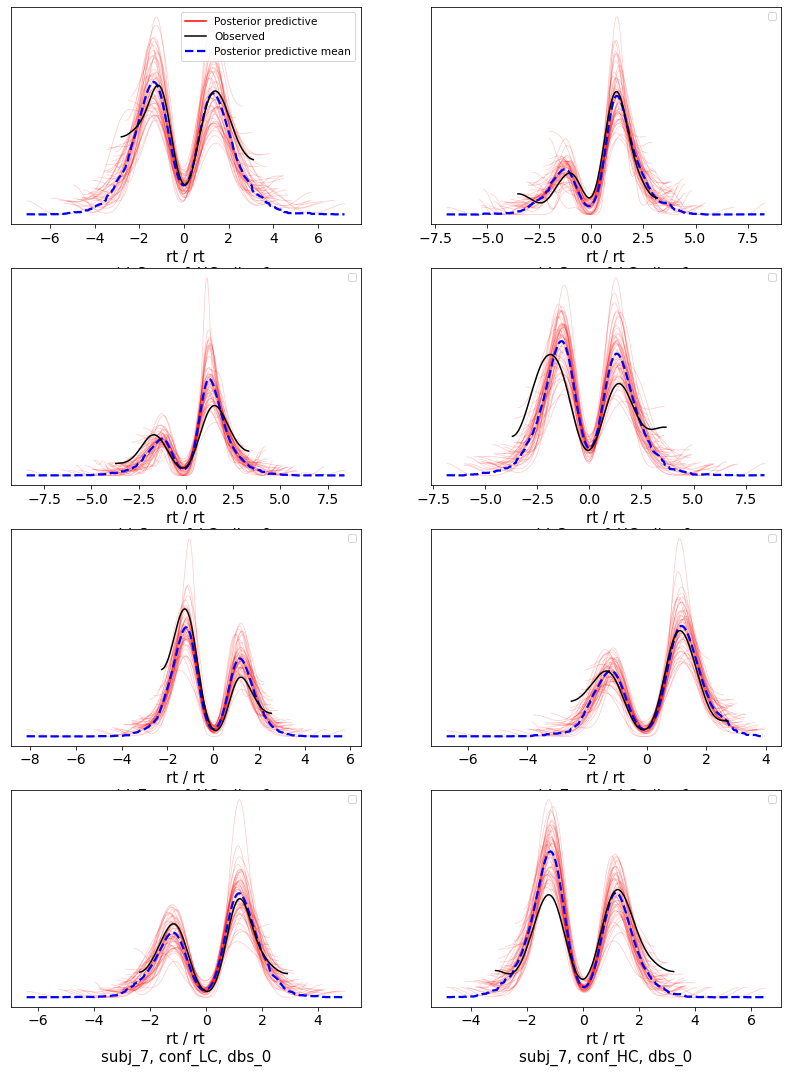

In [11]:
from plot_ppc_by_cond import plot_ppc_by_cond

or_d = hddm.load_csv('/opt/conda/lib/python3.7/site-packages/hddm/examples/cavanagh_theta_nn.csv')

plot_ppc_by_cond(data = InfData['ms7'],
                 or_d = or_d,
                 subjs = [3,7],
#                  conds = ['conf'],
                 conds = ['conf','dbs'],
#                  conds = {'conf': ['HC', 'LC', 'HC', 'LC'],
#                          'dbs': [0, 0, 1, 1]},
                 colors = ['r', 'k', 'b'],
                 num_pp_samples=200,
                 alpha = 0.2,
                 grid = [4,2],
                 var_names=['rt'])

In [11]:
from func4PPCPlot import _var_names, _subset_list, BaseLabeller, filter_plotters_list 
from func4PPCPlot import xarray_sel_iter, xarray_var_iter, _dims, _zip_dims
from func4PPCPlot import default_grid, get_plotting_function
from rcparams import rcParams
from numbers import Integral

In [14]:
def plot_ppc_by_cond(
    data,
    or_d=None, # original dataset
    subjs=None,     # subject's index
    conds=None,     # condition
    kind="kde",
    alpha=None,
    mean=True,
    observed=True,
    color=None,
    colors=None,
    grid=None,
    figsize=None,
    textsize=None,
    data_pairs=None,
    var_names=None,
    filter_vars=None,
    coords=None,
    flatten=None,
    flatten_pp=None,
    num_pp_samples=None,
    random_seed=None,
    jitter=None,
    animated=False,
    animation_kwargs=None,
    legend=True,
    labeller=None,
    ax=None,
    backend=None,
    backend_kwargs=None,
    group="posterior",
    show=None,
):
    """
    Plot for posterior/prior predictive checks.

    Parameters
    ----------

    """
    from itertools import product
    from func4PPCPlot import _var_names, _subset_list, BaseLabeller, filter_plotters_list 
    from func4PPCPlot import xarray_sel_iter, xarray_var_iter, _dims, _zip_dims
    from func4PPCPlot import default_grid, get_plotting_function
    from rcparams import rcParams
    from numbers import Integral
    
    if group not in ("posterior", "prior"):
        raise TypeError("`group` argument must be either `posterior` or `prior`")

    for groups in (f"{group}_predictive", "observed_data"):
        if not hasattr(data, groups):
            raise TypeError(f'`data` argument must have the group "{groups}" for ppcplot')

    if kind.lower() not in ("kde", "cumulative", "scatter"):
        raise TypeError("`kind` argument must be either `kde`, `cumulative`, or `scatter`")

    if colors is None:
        colors = ["C0", "k", "C1"]

    if isinstance(colors, str):
        raise TypeError("colors should be a list with 3 items.")

    if len(colors) != 3:
        raise ValueError("colors should be a list with 3 items.")

    if color is not None:
        warnings.warn("color has been deprecated in favor of colors", FutureWarning)
        colors[0] = color

    if data_pairs is None:
        data_pairs = {}

    if backend is None:
        backend = rcParams["plot.backend"]
    backend = backend.lower()
    if backend == "bokeh":
        if animated:
            raise TypeError("Animation option is only supported with matplotlib backend.")

    observed_data = data.observed_data

    if group == "posterior":
        predictive_dataset = data.posterior_predictive
    elif group == "prior":
        predictive_dataset = data.prior_predictive

    if coords is None:
        coords = {}

    if labeller is None:
        labeller = BaseLabeller()

    if random_seed is not None:
        np.random.seed(random_seed)

    total_pp_samples = predictive_dataset.sizes["chain"] * predictive_dataset.sizes["draw"]
    if num_pp_samples is None:
        if kind == "scatter" and not animated:
            num_pp_samples = min(5, total_pp_samples)
        else:
            num_pp_samples = total_pp_samples

    if (
        not isinstance(num_pp_samples, Integral)
        or num_pp_samples < 1
        or num_pp_samples > total_pp_samples
    ):
        raise TypeError(
            "`num_pp_samples` must be an integer between 1 and " + f"{total_pp_samples}."
        )

    pp_sample_ix = np.random.choice(total_pp_samples, size=num_pp_samples, replace=False)

    for key in coords.keys():
        coords[key] = np.where(np.in1d(observed_data[key], coords[key]))[0]
        
    obs_plotters = []
    pp_plotters = []

    if conds is None:
        dim_tmp = ['subj_idx']
        level_ls = subjs
    else:
        dim_tmp = ['subj_idx'] + conds
    #     levels = list(chain(or_d[conds].drop_duplicates().values.tolist()))
        levels = or_d[conds].drop_duplicates().values.tolist()
        level_ls = list(product(subjs, levels))


    # convert tuple to a dict
    levels_ls_tmp= {}
    for ii in range(len(level_ls)):
        tmp = level_ls[ii]
        levels_ls_tmp[ii] = []
        if (isinstance(tmp, int)) or (isinstance(tmp, str)):
            levels_ls_tmp[ii].append(tmp)
        else: #  isinstance(tmp, list):
            for jj in tmp:
    #             print(jj)
                if (isinstance(jj, int)) or (isinstance(jj, str)):
                    levels_ls_tmp[ii].append(jj)
                else:
                    levels_ls_tmp[ii]  = levels_ls_tmp[ii] + jj

    # dict's value to list       
    level_ls = list(levels_ls_tmp.values())

    for level in level_ls:
        print(level)
        # combine the subj_idx with conditions
        crit_tmp=[]
        for i, j in zip(dim_tmp, level):
            if isinstance(j, str):
                crit_tmp.append(i + "=='" + str(j) + "'")
            else:
                crit_tmp.append(i + "==" + str(j))

        crit_tmp = " and ".join(crit_tmp) # combine the conditions
        plot_idx = or_d.query(crit_tmp).index

        data_tmp = data.isel(trial_idx=plot_idx)

        observed_data_tmp = data_tmp.observed_data
        predictive_data_tmp = data_tmp.posterior_predictive

        if var_names is None:
            var_names = list(observed_data_tmp.data_vars)
        data_pairs = {}
        var_names = _var_names(var_names, observed_data_tmp, None)
        pp_var_names = [data_pairs.get(var, var) for var in var_names]
        pp_var_names = _var_names(pp_var_names, predictive_data_tmp, None)

        flatten_pp = None
        flatten = None
        num_pp_samples = 50
        coords = {}

        if flatten_pp is None and flatten is None:
            flatten_pp = list(predictive_data_tmp.dims.keys())
        elif flatten_pp is None:
            flatten_pp = flatten
        if flatten is None:
            flatten = list(observed_data_tmp.dims.keys())

        total_pp_samples = predictive_data_tmp.sizes["chain"] * predictive_data_tmp.sizes["draw"]

        pp_sample_ix = np.random.choice(total_pp_samples, size=num_pp_samples, replace=False)

        for key in coords.keys():
            coords[key] = np.where(np.in1d(observed_data_tmp[key], coords[key]))[0]

        obs_plotters_tmp = filter_plotters_list(
            list(
                xarray_var_iter(
                    observed_data_tmp.isel(coords),
                    skip_dims=set(flatten),
                    var_names=var_names,
                    combined=True,
                )
            ),
            "plot_ppc",
        )

        length_plotters_tmp = len(obs_plotters_tmp)
        pp_plotters_tmp = [
            tup
            for _, tup in zip(
                range(length_plotters_tmp),
                xarray_var_iter(
                    predictive_data_tmp.isel(coords),
                    var_names=pp_var_names,
                    skip_dims=set(flatten_pp),
                    combined=True,
                ),
            )
        ]

        for var_idx in range(len(var_names)):
            tmp0 = list(obs_plotters_tmp[0])
            tmp1 = list(pp_plotters_tmp[0])
            for i, j in zip(dim_tmp, level):
                if i == "subj_idx":        
                    tmp0[1][i] = "subj_" + str(j)
                    tmp0[2][i] = "subj_" + str(j)
                    tmp1[1][i] = "subj_" + str(j)
                    tmp1[2][i] = "subj_" + str(j)
                else:
                    tmp0[1][i] = i + "_" + str(j)
                    tmp0[2][i] = i + "_" + str(j)
                    tmp1[1][i] = i + "_" + str(j)
                    tmp1[2][i] = i + "_" + str(j)

            obs_plotters.append(tuple(tmp0))
            pp_plotters.append(tuple(tmp1))
                    
    length_plotters = len(obs_plotters)
    rows, cols = default_grid(length_plotters, grid=grid)

    ppcplot_kwargs = dict(
        ax=ax,
        length_plotters=length_plotters,
        rows=rows,
        cols=cols,
        figsize=figsize,
        animated=animated,
        obs_plotters=obs_plotters,
        pp_plotters=pp_plotters,
        predictive_dataset=predictive_dataset,
        pp_sample_ix=pp_sample_ix,
        kind=kind,
        alpha=alpha,
        colors=colors,
        jitter=jitter,
        textsize=textsize,
        mean=mean,
        observed=observed,
        total_pp_samples=total_pp_samples,
        legend=legend,
        labeller=labeller,
        group=group,
        animation_kwargs=animation_kwargs,
        num_pp_samples=num_pp_samples,
        backend_kwargs=backend_kwargs,
        show=show,
    )

    # TODO: Add backend kwargs
    plot = get_plotting_function("plot_ppc", "ppcplot", backend)
    axes = plot(**ppcplot_kwargs)
    return axes


[3, 'HC', 1]
[3, 'LC', 1]
[3, 'LC', 0]
[3, 'HC', 0]
[7, 'HC', 1]
[7, 'LC', 1]
[7, 'LC', 0]
[7, 'HC', 0]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc0a00794d0>,
      dtype=object)

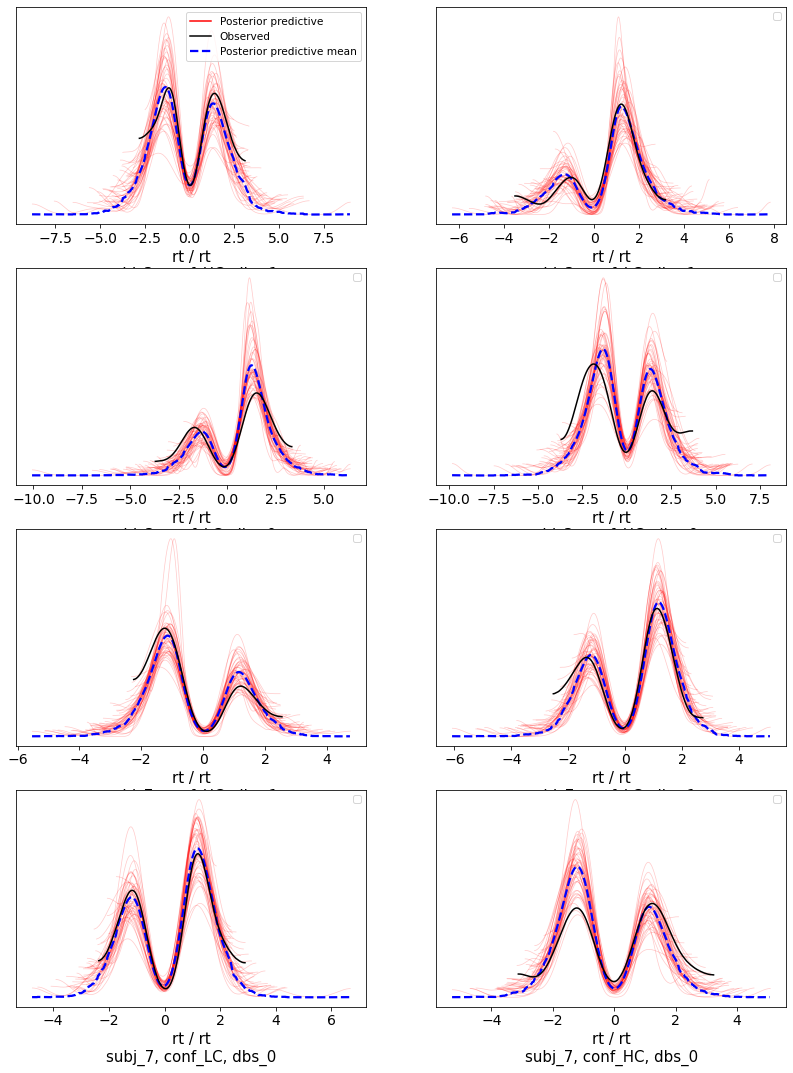

In [12]:
or_d = hddm.load_csv('/opt/conda/lib/python3.7/site-packages/hddm/examples/cavanagh_theta_nn.csv')

plot_ppc_by_cond(data = InfData['ms7'],
                 or_d = or_d,
                 subjs = [3,7],
#                  conds = ['conf'],
                 conds = ['conf','dbs'],
#                  conds = {'conf': ['HC', 'LC', 'HC', 'LC'],
#                          'dbs': [0, 0, 1, 1]},
                 colors = ['r', 'k', 'b'],
                 num_pp_samples=200,
                 alpha = 0.2,
                 grid = [4,2],
                 var_names=['rt'])

In [20]:
data = InfData['ms7']
subjs = [1, 5]
# conds = None
conds = ['conf']
var_names = ['rt']
# conds = ['conf', 'dbs']
#                  conds = {'conf': ['HC', 'LC', 'HC', 'LC'],
#                          'dbs': [0, 0, 1, 1]},

for subj_idx in subjs:
    print(subj_idx)
    if conds is None:  # no conditions
        print("no condition, only subj")
        plot_idx = or_d[(or_d.subj_idx == subj_idx)].index

    else:
        levels = or_d[conds].drop_duplicates()

        conds_new = {}  # generate a dict for later use
        for cond_idx in conds:
            conds_new[cond_idx] = list(levels[cond_idx])

        if len(conds) == 1:
            for level_idx in range(len(conds_new[conds[0]])):
                cond0_idx = conds_new[conds[0]][level_idx]
                print(subj_idx, cond0_idx)
                plot_idx = or_d[(or_d.subj_idx == subj_idx) & (or_d[conds[0]] == cond0_idx)].index
        elif len(conds) == 2:
            for level_idx in range(len(conds_new[conds[0]])):
                cond0_idx = conds_new[conds[0]][level_idx]
                cond1_idx = conds_new[conds[1]][level_idx]
                print(subj_idx, cond0_idx, cond1_idx)
                plot_idx = or_d[(or_d.subj_idx == subj_idx) & (or_d[conds[0]] == cond0_idx) & (or_d[conds[1]]==cond0_idx)].index

    data_tmp = data.isel(trial_idx=plot_idx)
    
    obs_plotters = []
    pp_plotters = []

    for subj_idx in subjs:
        if conds is None:  # no conditions
            print("no condition, only subj")
            plot_idx = or_d[(or_d.subj_idx == subj_idx)].index

        else:
            levels = or_d[conds].drop_duplicates()

            conds_new = {}  # generate a dict for later use
            for cond_idx in conds:
                conds_new[cond_idx] = list(levels[cond_idx])

            if len(conds) == 1:
                for level_idx in range(len(conds_new[conds[0]])):
                    cond0_idx = conds_new[conds[0]][level_idx]
                    print(subj_idx, cond0_idx)
                    plot_idx = or_d[(or_d.subj_idx == subj_idx) & (or_d[conds[0]] == cond0_idx)].index
            elif len(conds) == 2:
                for level_idx in range(len(conds_new[conds[0]])):
                    cond0_idx = conds_new[conds[0]][level_idx]
                    cond1_idx = conds_new[conds[1]][level_idx]
                    print(subj_idx, cond0_idx, cond1_idx)
                    plot_idx = or_d[(or_d.subj_idx == subj_idx) & (or_d[conds[0]] == cond0_idx) & (or_d[conds[1]]==cond0_idx)].index
            
        data_tmp = data.isel(trial_idx=plot_idx)

        observed_data_tmp = data_tmp.observed_data
        predictive_data_tmp = data_tmp.posterior_predictive

        if var_names is None:
            var_names = list(observed_data_tmp.data_vars)
        data_pairs = {}
        var_names = _var_names(var_names, observed_data_tmp, None)
        pp_var_names = [data_pairs.get(var, var) for var in var_names]
        pp_var_names = _var_names(pp_var_names, predictive_data_tmp, None)

        flatten_pp = None
        flatten = None
        num_pp_samples = 50
        coords = {}
        
        if flatten_pp is None and flatten is None:
            flatten_pp = list(predictive_data_tmp.dims.keys())
        elif flatten_pp is None:
            flatten_pp = flatten
        if flatten is None:
            flatten = list(observed_data_tmp.dims.keys())

        total_pp_samples = predictive_data_tmp.sizes["chain"] * predictive_data_tmp.sizes["draw"]

        pp_sample_ix = np.random.choice(total_pp_samples, size=num_pp_samples, replace=False)

        for key in coords.keys():
            coords[key] = np.where(np.in1d(observed_data_tmp[key], coords[key]))[0]

        obs_plotters_tmp = filter_plotters_list(
            list(
                xarray_var_iter(
                    observed_data_tmp.isel(coords),
                    skip_dims=set(flatten),
                    var_names=var_names,
                    combined=True,
                )
            ),
            "plot_ppc",
        )

        length_plotters_tmp = len(obs_plotters_tmp)
        pp_plotters_tmp = [
            tup
            for _, tup in zip(
                range(length_plotters_tmp),
                xarray_var_iter(
                    predictive_data_tmp.isel(coords),
                    var_names=pp_var_names,
                    skip_dims=set(flatten_pp),
                    combined=True,
                ),
            )
        ]
        for ls_idx in range(len(var_names)):
            tmp0 = list(obs_plotters_tmp[0])
            tmp0[1]['subj_idx'] = "subj_" + str(subj_idx)
            tmp0[2]['subj_idx'] = "subj_" + str(subj_idx)
            
            if (conds is not None) & (len(conds) == 1):  # no conditions
                tmp0[1][conds[0]] = 
                
            tmp0[1]['conf'] = conf_idx
            tmp0[1]['dbs'] = "dbs_" + str(dbs_idx)
            tmp0[2]['conf'] = conf_idx
            tmp0[2]['dbs'] = "dbs_" + str(dbs_idx)

            tmp1 = list(pp_plotters_tmp[0])
            tmp1[1]['subj_idx'] = "subj_" + str(subj_idx)
            tmp1[1]['conf'] = conf_idx
            tmp1[1]['dbs'] = "dbs_" + str(dbs_idx)
            tmp1[2]['subj_idx'] = "subj_" + str(subj_idx)
            tmp1[2]['conf'] = conf_idx
            tmp1[2]['dbs'] = "dbs_" + str(dbs_idx)

            obs_plotters.append(tuple(tmp0))
            pp_plotters.append(tuple(tmp1))
                    

1
1 HC
1 LC
1 HC
1 LC


NameError: name 'conf_idx' is not defined

In [22]:
conds_new

{'conf': ['HC', 'LC']}

In [25]:
cond0_idx

'LC'

In [24]:
conds_new[conds[0]][level_idx]

'LC'

In [34]:
dim_tmp = ['subj_idx', 'conf', 'dbs']
val_tmp = [0, 'HC', 0]

crit_tmp = []
for i, j in zip(dim_tmp, val_tmp):
    if isinstance(j, str):
        crit_tmp.append(i + "=='" + str(j) + "'")
    else:
        crit_tmp.append(i + "==" + str(j))

crit_tmp2 = " and ".join(crit_tmp)
crit_tmp2

"subj_idx==0 and conf=='HC' and dbs==0"

In [35]:
or_d.query(crit_tmp2)

subj_idx stim     rt  response     theta  dbs conf
151         0   LL  1.230       1.0  0.414486    0   HC
152         0   WW  1.920       1.0 -1.285671    0   HC
154         0   WW  2.690       0.0 -0.894475    0   HC
157         0   LL  2.380       1.0  0.174652    0   HC
159         0   WW  1.310       0.0  0.718276    0   HC
..        ...  ...    ...       ...       ...  ...  ...
290         0   WW  0.796       1.0 -0.265577    0   HC
291         0   LL  1.230       0.0 -0.090764    0   HC
292         0   WW  2.600       1.0  0.782232    0   HC
295         0   LL  1.160       0.0  1.203274    0   HC
297         0   WW  1.500       1.0 -0.335928    0   HC

[74 rows x 7 columns]

In [192]:
subjs = [1, 5]
conds = None
# conds = ['dbs']
# conds = ['conf', 'dbs']
#                  conds = {'conf': ['HC', 'LC', 'HC', 'LC'],
#                          'dbs': [0, 0, 1, 1]},

In [184]:
from itertools import product
from itertools import chain
if conds is None:
    dim_tmp = ['subj_idx']
    level_ls = subjs
else:
    dim_tmp = ['subj_idx'] + conds
#     levels = list(chain(or_d[conds].drop_duplicates().values.tolist()))
    levels = or_d[conds].drop_duplicates().values.tolist()
    
    level_ls = list(product(subjs, levels))

levels_ls_tmp= {}
for ii in range(len(level_ls)):
#     print(level_ls[ii])
    tmp = level_ls[ii]
    levels_ls_tmp[ii] = []
    
    if (isinstance(tmp, int)) or (isinstance(tmp, str)):
        levels_ls_tmp[ii].append(tmp)
    else: #  isinstance(tmp, list):
        for jj in tmp:
#             print(jj)
            if (isinstance(jj, int)) or (isinstance(jj, str)):
                levels_ls_tmp[ii].append(jj)
            else:
                levels_ls_tmp[ii]  = levels_ls_tmp[ii] + jj
#     else:
#         levels_ls_tmp[ii]  = levels_ls_tmp[ii] + level_ls[ii]
        
level_ls = list(levels_ls_tmp.values())

print('dim_tmp', dim_tmp)
print('level_ls', level_ls)

dim_tmp ['subj_idx', 'conf', 'dbs']
level_ls [[1, 'HC', 1], [1, 'LC', 1], [1, 'LC', 0], [1, 'HC', 0], [5, 'HC', 1], [5, 'LC', 1], [5, 'LC', 0], [5, 'HC', 0]]


In [210]:
pp_plotters_tmp

[('rt',
  {'subj_idx': 'subj_5'},
  {'subj_idx': 'subj_5'},
  array([[[-2.14027905, -1.72991937,  2.96056723, ..., -0.85860341,
           -2.01025515,  0.47321358],
          [ 1.56199005,  0.60736647,  2.03031585, ..., -1.87802899,
           -2.44058204,  0.39605752],
          [ 0.71219082, -1.45949827, -0.69067041, ...,  0.42324249,
           -1.01617468,  0.57106527],
          ...,
          [-1.52079147, -1.11306014,  2.29343353, ...,  0.85817931,
           -0.58216616, -0.963321  ],
          [ 1.77085249,  1.46102708,  0.96041864, ...,  0.81320015,
            1.35876888,  0.46044339],
          [-0.93772529, -0.94153745,  0.42244644, ..., -1.80672784,
            0.62747303,  0.97394483]],
  
         [[ 0.71756578,  0.9723448 , -0.6063421 , ...,  0.87791584,
            1.13639813,  0.57530533],
          [-0.47823031, -0.51509605,  0.71629114, ..., -0.71981649,
            1.05058563,  2.21381788],
          [ 1.62117941,  0.74395437, -1.28552267, ...,  1.16440024,
     

In [211]:
from itertools import product
from itertools import chain

obs_plotters = []
pp_plotters = []
if conds is None:
    dim_tmp = ['subj_idx']
    level_ls = subjs
else:
    dim_tmp = ['subj_idx'] + conds
#     levels = list(chain(or_d[conds].drop_duplicates().values.tolist()))
    levels = or_d[conds].drop_duplicates().values.tolist()
    
    level_ls = list(product(subjs, levels))

# convert tuple to a dict
levels_ls_tmp= {}
for ii in range(len(level_ls)):
#     print(level_ls[ii])
    tmp = level_ls[ii]
    levels_ls_tmp[ii] = []
    
    if (isinstance(tmp, int)) or (isinstance(tmp, str)):
        levels_ls_tmp[ii].append(tmp)
    else: #  isinstance(tmp, list):
        for jj in tmp:
#             print(jj)
            if (isinstance(jj, int)) or (isinstance(jj, str)):
                levels_ls_tmp[ii].append(jj)
            else:
                levels_ls_tmp[ii]  = levels_ls_tmp[ii] + jj

# dict's value to list       
level_ls = list(levels_ls_tmp.values())

for level in level_ls:
    print(level)
    # combine the subj_idx with conditions
    crit_tmp=[]
    for i, j in zip(dim_tmp, level):
        if isinstance(j, str):
            crit_tmp.append(i + "=='" + str(j) + "'")
        else:
            crit_tmp.append(i + "==" + str(j))
    
    crit_tmp = " and ".join(crit_tmp) # combine the conditions
    plot_idx = or_d.query(crit_tmp).index
    
    data_tmp = data.isel(trial_idx=plot_idx)

    observed_data_tmp = data_tmp.observed_data
    predictive_data_tmp = data_tmp.posterior_predictive

    if var_names is None:
        var_names = list(observed_data_tmp.data_vars)
    data_pairs = {}
    var_names = _var_names(var_names, observed_data_tmp, None)
    pp_var_names = [data_pairs.get(var, var) for var in var_names]
    pp_var_names = _var_names(pp_var_names, predictive_data_tmp, None)

    flatten_pp = None
    flatten = None
    num_pp_samples = 50
    coords = {}

    if flatten_pp is None and flatten is None:
        flatten_pp = list(predictive_data_tmp.dims.keys())
    elif flatten_pp is None:
        flatten_pp = flatten
    if flatten is None:
        flatten = list(observed_data_tmp.dims.keys())

    total_pp_samples = predictive_data_tmp.sizes["chain"] * predictive_data_tmp.sizes["draw"]

    pp_sample_ix = np.random.choice(total_pp_samples, size=num_pp_samples, replace=False)

    for key in coords.keys():
        coords[key] = np.where(np.in1d(observed_data_tmp[key], coords[key]))[0]

    obs_plotters_tmp = filter_plotters_list(
        list(
            xarray_var_iter(
                observed_data_tmp.isel(coords),
                skip_dims=set(flatten),
                var_names=var_names,
                combined=True,
            )
        ),
        "plot_ppc",
    )

    length_plotters_tmp = len(obs_plotters_tmp)
    pp_plotters_tmp = [
        tup
        for _, tup in zip(
            range(length_plotters_tmp),
            xarray_var_iter(
                predictive_data_tmp.isel(coords),
                var_names=pp_var_names,
                skip_dims=set(flatten_pp),
                combined=True,
            ),
        )
    ]
    
    for var_idx in range(len(var_names)):
        tmp0 = list(obs_plotters_tmp[0])
        tmp1 = list(pp_plotters_tmp[0])
        for i, j in zip(dim_tmp, level):
            if i == "subj_idx":        
                tmp0[1][i] = "subj_" + str(j)
                tmp0[2][i] = "subj_" + str(j)
                tmp1[1][i] = "subj_" + str(j)
                tmp1[2][i] = "subj_" + str(j)
            else:
                tmp0[1][i] = i + "_" + str(j)
                tmp0[2][i] = i + "_" + str(j)
                tmp1[1][i] = i + "_" + str(j)
                tmp1[2][i] = i + "_" + str(j)

        obs_plotters.append(tuple(tmp0))
        pp_plotters.append(tuple(tmp1))


[1]
[5]


In [213]:
pp_plotters

[('rt',
  {'subj_idx': 'subj_1'},
  {'subj_idx': 'subj_1'},
  array([[[ 3.12100736,  1.88211477, -0.77390116, ...,  0.55378765,
            0.55706227, -1.50504205],
          [ 1.86264156,  1.66541273,  1.26426498, ...,  0.5081829 ,
            1.89094301,  0.85641635],
          [ 1.49956436,  1.7655472 , -2.68967649, ..., -3.92150219,
            0.98798607, -0.83775551],
          ...,
          [ 1.16088228,  1.24441826,  0.83377653, ...,  0.77968866,
            1.58617915,  2.29983119],
          [ 1.29791924,  2.23516166,  0.77489982, ...,  0.65861788,
            2.02780948,  0.82972526],
          [ 1.22228387,  1.457948  ,  3.53373215, ...,  1.53441398,
            1.22313793,  0.67012056]],
  
         [[ 2.03073901,  2.56445689,  0.87851305, ...,  1.15218718,
            0.99870029,  1.43153277],
          [ 0.93759671,  1.09919006,  0.93385468, ..., -0.69818989,
           -0.90146897, -1.55308023],
          [ 1.21605243, -0.93704206, -1.0558993 , ...,  0.75456798,
     

In [152]:
levels_ls_tmp

{0: []}

In [142]:
dim_tmp

['subj_idx', 'conf', 'dbs']

In [112]:
' '.join(level_ls[ii])

TypeError: sequence item 0: expected str instance, int found

In [111]:
len(level_ls[ii]) 

2

In [102]:
len(level_ls)

8

In [97]:
or_d[conds].drop_duplicates().values.tolist()

[['HC'], ['LC']]

In [98]:
list(chain(or_d[conds].drop_duplicates().values.tolist()))

[['HC'], ['LC']]

In [87]:
list(level_ls)

[(1, ['HC', 1]),
 (1, ['LC', 1]),
 (1, ['LC', 0]),
 (1, ['HC', 0]),
 (5, ['HC', 1]),
 (5, ['LC', 1]),
 (5, ['LC', 0]),
 (5, ['HC', 0])]

In [88]:
[ "%s %s" % x for x in level_ls ]

["1 ['HC', 1]",
 "1 ['LC', 1]",
 "1 ['LC', 0]",
 "1 ['HC', 0]",
 "5 ['HC', 1]",
 "5 ['LC', 1]",
 "5 ['LC', 0]",
 "5 ['HC', 0]"]

In [138]:
for level in level_ls:
    crit_tmp=[]
    for i, j in zip(dim_tmp, level):
#         print(i, j, '\n')
        if isinstance(j, str):
            crit_tmp.append(i + "=='" + str(j) + "'")
        else:
            crit_tmp.append(i + "==" + str(j))

    crit_tmp = " and ".join(crit_tmp)
    plot_idx = or_d.query(crit_tmp).index
    print(plot_idx)
#     print(crit_tmp, '\n')

Int64Index([300, 301, 304, 307, 308, 310, 312, 314, 315, 317, 319, 322, 323,
            324, 325, 328, 331, 332, 333, 337, 338, 340, 341, 345, 346, 349,
            351, 352, 353, 357, 361, 362, 365, 366, 368, 369, 371, 375, 376,
            378, 379, 381, 382, 387, 388, 389, 392, 393, 395, 396, 399, 401,
            402, 406, 408, 410, 411, 412, 415, 417, 419, 422, 424, 425, 427,
            429, 431, 432, 434, 437, 439, 442, 443, 446, 447],
           dtype='int64')
Int64Index([298, 299, 302, 303, 305, 306, 309, 311, 313, 316, 318, 320, 321,
            326, 327, 329, 330, 334, 335, 336, 339, 342, 343, 344, 347, 348,
            350, 354, 355, 356, 358, 359, 360, 363, 364, 367, 370, 372, 373,
            374, 377, 380, 383, 384, 385, 386, 390, 391, 394, 397, 398, 400,
            403, 404, 405, 407, 409, 413, 414, 416, 418, 420, 421, 423, 426,
            428, 430, 433, 435, 436, 438, 440, 441, 444, 445, 448],
           dtype='int64')
Int64Index([451, 452, 453, 454, 456, 458, 459, 

In [72]:
levels

[['HC', 1], ['LC', 1], ['LC', 0], ['HC', 0]]

In [76]:
type(level_ls[0][1])

list

['HC', 'LC']

In [54]:
or_d[conds].drop_duplicates()

conf
0   HC
1   LC

In [51]:
type(levels)

pandas.core.frame.DataFrame

In [50]:
type(subjs)

list

In [49]:
list(product(subjs, levels))

[(1, 'conf'), (5, 'conf')]

In [42]:
['subj_idx'].append(conds)

In [77]:
for subj_idx in subjs:
    if conds is None:  # no conditions
        print("no condition, only subj")
        plot_idx = or_d[(or_d.subj_idx == subj_idx)]
        
    else:
        levels = or_d[conds].drop_duplicates()
        
        conds_new = {}  # generate a dict for later use
        for cond_idx in conds:
            conds_new[cond_idx] = list(levels[cond_idx])
        
        if len(conds) == 1:
            for level_idx in range(len(conds_new[conds[0]])):
                cond0_idx = conds_new[conds[0]][level_idx]
                print(subj_idx, cond0_idx)
                plot_idx = or_d[(or_d.subj_idx == subj_idx) & (or_d[conds[0]] == cond0_idx)].index
        elif len(conds) == 2:
            for level_idx in range(len(conds_new[conds[0]])):
                cond0_idx = conds_new[conds[0]][level_idx]
                cond1_idx = conds_new[conds[1]][level_idx]
                print(subj_idx, cond0_idx, cond1_idx)
                plot_idx = or_d[(or_d.subj_idx == subj_idx) & (or_d[conds[0]] == cond0_idx) & (or_d[conds[1]]==cond0_idx)].index

1 HC 1
1 LC 1
1 LC 0
1 HC 0
5 HC 1
5 LC 1
5 LC 0
5 HC 0


In [60]:
conds_ls = list(product(pd.unique(or_d[conds[0]]), pd.unique(or_d[conds[1]])))
conds_ls

[('HC', 1), ('HC', 0), ('LC', 1), ('LC', 0)]

In [55]:
for i, (k, v) in enumerate(conds_new.items()):
    print(i)
    print(k)
    print(v)

0
conf
['HC', 'LC', 'LC', 'HC']
1
dbs
[1, 1, 0, 0]


In [53]:
conds_new['conf']

0      HC
1      LC
150    LC
151    HC
Name: conf, dtype: object

In [32]:
from itertools import product
subjs = [1, 5]
cond = {'conf': ['HC', 'LC'],
        'dbs': [0, 1]}

subjs_tmp = ['S' + str(i) for i in subjs]

# convert keys
conds_tmp = {}
for i, (k, v) in enumerate(cond.items()):
#     print(i)
#     print(k)
    conds_tmp['cond_' + str(i)] = [k + "_" + str(j) for j in v]
conds_tmp


{'cond_0': ['conf_HC', 'conf_LC'], 'cond_1': ['dbs_0', 'dbs_1']}

In [45]:
cond_ls = list(product(cond['conf'], cond['dbs']))
cond_ls = dict(cond_ls)
cond_ls

{'HC': 1, 'LC': 1}

In [42]:

cond_new = {}
for i in cond_ls:
    if 'cond_0' not in cond_new: 
        cond_new['cond_0'] = []
        cond_new['cond_0'].append(i[0])
    else:
        cond_new['cond_0'].append(i[0])
    if 'cond_1' not in cond_new:
        cond_new['cond_1']= []
        cond_new['cond_1'].append(i[1])
    else:
        cond_new['cond_1'].append(i[1])
        
cond_new

{'cond_0': ['HC', 'HC', 'LC', 'LC'], 'cond_1': [0, 1, 0, 1]}

In [ ]:
cond_ls = list(product(conds_tmp['cond_0'], conds_tmp['cond_1']))
cond_ls

In [30]:
or_d = hddm.load_csv('/opt/conda/lib/python3.7/site-packages/hddm/examples/cavanagh_theta_nn.csv')


In [ ]:
from itertools import product

l1, l2 = [1, 2, 3], ['a', 'b']
output = list(product(l1, l2))

or_d = hddm.load_csv('/opt/conda/lib/python3.7/site-packages/hddm/examples/cavanagh_theta_nn.csv')

plot_ppc_by_cond(data = InfData['ms7'],
                 or_d = or_d,
                 subjs = [1, 5],
                 cond = {'conf': ['HC', 'LC', 'HC', 'LC'],
                         'dbs': [0, 0, 1, 1]},
                 colors = ['r', 'k', 'b'],
                 num_pp_samples=100,
                 alpha = 0.2,
                 var_names=['rt'])

In [11]:
def _var_names(var_names, data, filter_vars=None):
    """Handle var_names input across arviz.
    Parameters
    ----------
    var_names: str, list, or None
    data : xarray.Dataset
        Posterior data in an xarray
    filter_vars: {None, "like", "regex"}, optional, default=None
        If `None` (default), interpret var_names as the real variables names. If "like",
         interpret var_names as substrings of the real variables names. If "regex",
         interpret var_names as regular expressions on the real variables names. A la
        `pandas.filter`.
    Returns
    -------
    var_name: list or None
    """
    if filter_vars not in {None, "like", "regex"}:
        raise ValueError(
            f"'filter_vars' can only be None, 'like', or 'regex', got: '{filter_vars}'"
        )

    if var_names is not None:
        if isinstance(data, (list, tuple)):
            all_vars = []
            for dataset in data:
                dataset_vars = list(dataset.data_vars)
                for var in dataset_vars:
                    if var not in all_vars:
                        all_vars.append(var)
        else:
            all_vars = list(data.data_vars)

        all_vars_tilde = [var for var in all_vars if var.startswith("~")]
        if all_vars_tilde:
            warnings.warn(
                """ArviZ treats '~' as a negation character for variable selection.
                   Your model has variables names starting with '~', {0}. Please double check
                   your results to ensure all variables are included""".format(
                    ", ".join(all_vars_tilde)
                )
            )

        try:
            var_names = _subset_list(var_names, all_vars, filter_items=filter_vars, warn=False)
        except KeyError as err:
            msg = " ".join(("var names:", f"{err}", "in dataset"))
            raise KeyError(msg) from err
    return var_names

def _subset_list(subset, whole_list, filter_items=None, warn=True):
    """Handle list subsetting (var_names, groups...) across arviz.
    Parameters
    ----------
    subset : str, list, or None
    whole_list : list
        List from which to select a subset according to subset elements and
        filter_items value.
    filter_items : {None, "like", "regex"}, optional
        If `None` (default), interpret `subset` as the exact elements in `whole_list`
        names. If "like", interpret `subset` as substrings of the elements in
        `whole_list`. If "regex", interpret `subset` as regular expressions to match
        elements in `whole_list`. A la `pandas.filter`.
    Returns
    -------
    list or None
        A subset of ``whole_list`` fulfilling the requests imposed by ``subset``
        and ``filter_items``.
    """
    if subset is not None:

        if isinstance(subset, str):
            subset = [subset]

        whole_list_tilde = [item for item in whole_list if item.startswith("~")]
        if whole_list_tilde and warn:
            warnings.warn(
                "ArviZ treats '~' as a negation character for selection. There are "
                "elements in `whole_list` starting with '~', {0}. Please double check"
                "your results to ensure all elements are included".format(
                    ", ".join(whole_list_tilde)
                )
            )

        excluded_items = [
            item[1:] for item in subset if item.startswith("~") and item not in whole_list
        ]
        filter_items = str(filter_items).lower()
        not_found = []

        if excluded_items:
            if filter_items in ("like", "regex"):
                for pattern in excluded_items[:]:
                    excluded_items.remove(pattern)
                    if filter_items == "like":
                        real_items = [real_item for real_item in whole_list if pattern in real_item]
                    else:
                        # i.e filter_items == "regex"
                        real_items = [
                            real_item for real_item in whole_list if re.search(pattern, real_item)
                        ]
                    if not real_items:
                        not_found.append(pattern)
                    excluded_items.extend(real_items)
            not_found.extend([item for item in excluded_items if item not in whole_list])
            if not_found:
                warnings.warn(
                    f"Items starting with ~: {not_found} have not been found and will be ignored"
                )
            subset = [item for item in whole_list if item not in excluded_items]

        else:
            if filter_items == "like":
                subset = [item for item in whole_list for name in subset if name in item]
            elif filter_items == "regex":
                subset = [item for item in whole_list for name in subset if re.search(name, item)]

        existing_items = np.isin(subset, whole_list)
        if not np.all(existing_items):
            raise KeyError(f"{np.array(subset)[~existing_items]} are not present")

    return subset


class BaseLabeller:
    """WIP."""
    from typing import Union
    def dim_coord_to_str(self, dim, coord_val, coord_idx):
        """WIP."""
        return f"{coord_val}"

    def sel_to_str(self, sel: dict, isel: dict):
        """WIP."""
        if not sel:
            return ""
        return ", ".join(
            [
                self.dim_coord_to_str(dim, v, i)
                for (dim, v), (_, i) in zip(sel.items(), isel.items())
            ]
        )

    def var_name_to_str(self, var_name: Union[str, None]):
        """WIP."""
        return var_name

    def var_pp_to_str(self, var_name, pp_var_name):
        """WIP."""
        var_name_str = self.var_name_to_str(var_name)
        pp_var_name_str = self.var_name_to_str(pp_var_name)
        return f"{var_name_str} / {pp_var_name_str}"

    def model_name_to_str(self, model_name):
        """WIP."""
        return model_name

    def make_label_vert(self, var_name: Union[str, None], sel: dict, isel: dict):
        """WIP."""
        var_name_str = self.var_name_to_str(var_name)
        sel_str = self.sel_to_str(sel, isel)
        if not sel_str:
            return var_name_str
        if var_name_str is None:
            return sel_str
        return f"{var_name_str}; {sel_str}"

    def make_label_flat(self, var_name: str, sel: dict, isel: dict):
        """WIP."""
        var_name_str = self.var_name_to_str(var_name)
        sel_str = self.sel_to_str(sel, isel)
        if not sel_str:
            return var_name_str
        if var_name is None:
            return sel_str
        return f"{var_name_str}[{sel_str}]"

    def make_pp_label(self, var_name, pp_var_name, sel, isel):
        """WIP."""
        names = self.var_pp_to_str(var_name, pp_var_name)
        return self.make_label_vert(names, sel, isel)

    def make_model_label(self, model_name, label):
        """WIP."""
        model_name_str = self.model_name_to_str(model_name)
        if model_name_str is None:
            return label
        return f"{model_name}: {label}"
    
def filter_plotters_list(plotters, plot_kind):
    """Cut list of plotters so that it is at most of length "plot.max_subplots"."""
    max_plots = rcParams["plot.max_subplots"]
    max_plots = len(plotters) if max_plots is None else max_plots
    if len(plotters) > max_plots:
        warnings.warn(
            "rcParams['plot.max_subplots'] ({max_plots}) is smaller than the number "
            "of variables to plot ({len_plotters}) in {plot_kind}, generating only "
            "{max_plots} plots".format(
                max_plots=max_plots, len_plotters=len(plotters), plot_kind=plot_kind
            ),
            UserWarning,
        )
        return plotters[:max_plots]
    return plotters

def xarray_sel_iter(data, var_names=None, combined=False, skip_dims=None, reverse_selections=False):
    """Convert xarray data to an iterator over variable names and selections.
    Iterates over each var_name and all of its coordinates, returning the variable
    names and selections that allow properly obtain the data from ``data`` as desired.
    Parameters
    ----------
    data : xarray.Dataset
        Posterior data in an xarray
    var_names : iterator of strings (optional)
        Should be a subset of data.data_vars. Defaults to all of them.
    combined : bool
        Whether to combine chains or leave them separate
    skip_dims : set
        dimensions to not iterate over
    reverse_selections : bool
        Whether to reverse selections before iterating.
    Returns
    -------
    Iterator of (var_name: str, selection: dict(str, any))
        The string is the variable name, the dictionary are coordinate names to values,.
        To get the values of the variable at these coordinates, do
        ``data[var_name].sel(**selection)``.
    """
    if skip_dims is None:
        skip_dims = set()

    if combined:
        skip_dims = skip_dims.union({"chain", "draw"})
    else:
        skip_dims.add("draw")

    if var_names is None:
        if isinstance(data, xr.Dataset):
            var_names = list(data.data_vars)
        elif isinstance(data, xr.DataArray):
            var_names = [data.name]
            data = {data.name: data}

    for var_name in var_names:
        if var_name in data:
            new_dims = _dims(data, var_name, skip_dims)
            vals = [purge_duplicates(data[var_name][dim].values) for dim in new_dims]
            dims = _zip_dims(new_dims, vals)
            idims = _zip_dims(new_dims, [range(len(v)) for v in vals])
            if reverse_selections:
                dims = reversed(dims)
                idims = reversed(idims)

            for selection, iselection in zip(dims, idims):
                yield var_name, selection, iselection

def xarray_var_iter(data, var_names=None, combined=False, skip_dims=None, reverse_selections=False):
    """Convert xarray data to an iterator over vectors.
    Iterates over each var_name and all of its coordinates, returning the 1d
    data.
    Parameters
    ----------
    data : xarray.Dataset
        Posterior data in an xarray
    var_names : iterator of strings (optional)
        Should be a subset of data.data_vars. Defaults to all of them.
    combined : bool
        Whether to combine chains or leave them separate
    skip_dims : set
        dimensions to not iterate over
    reverse_selections : bool
        Whether to reverse selections before iterating.
    Returns
    -------
    Iterator of (str, dict(str, any), np.array)
        The string is the variable name, the dictionary are coordinate names to values,
        and the array are the values of the variable at those coordinates.
    """
    data_to_sel = data
    if var_names is None and isinstance(data, xr.DataArray):
        data_to_sel = {data.name: data}

    for var_name, selection, iselection in xarray_sel_iter(
        data,
        var_names=var_names,
        combined=combined,
        skip_dims=skip_dims,
        reverse_selections=reverse_selections,
    ):
        yield var_name, selection, iselection, data_to_sel[var_name].sel(**selection).values

def _dims(data, var_name, skip_dims):
    return [dim for dim in data[var_name].dims if dim not in skip_dims]

from itertools import product, tee
def _zip_dims(new_dims, vals):
    from itertools import product, tee
    return [{k: v for k, v in zip(new_dims, prod)} for prod in product(*vals)]

from rcparams import rcParams

def default_grid(n_items, grid=None, max_cols=4, min_cols=3):  # noqa: D202
    """Make a grid for subplots.
    Tries to get as close to sqrt(n_items) x sqrt(n_items) as it can,
    but allows for custom logic
    Parameters
    ----------
    n_items : int
        Number of panels required
    grid : tuple
        Number of rows and columns
    max_cols : int
        Maximum number of columns, inclusive
    min_cols : int
        Minimum number of columns, inclusive
    Returns
    -------
    (int, int)
        Rows and columns, so that rows * columns >= n_items
    """

    if grid is None:

        def in_bounds(val):
            return np.clip(val, min_cols, max_cols)

        if n_items <= max_cols:
            return 1, n_items
        ideal = in_bounds(round(n_items ** 0.5))

        for offset in (0, 1, -1, 2, -2):
            cols = in_bounds(ideal + offset)
            rows, extra = divmod(n_items, cols)
            if extra == 0:
                return rows, cols
        return n_items // ideal + 1, ideal
    else:
        rows, cols = grid
        if rows * cols < n_items:
            raise ValueError("The number of rows times columns is less than the number of subplots")
        if (rows * cols) - n_items >= cols:
            warnings.warn("The number of rows times columns is larger than necessary")
        return rows, cols
    
import importlib
from numbers import Integral
def get_plotting_function(plot_name, plot_module, backend):
    """Return plotting function for correct backend."""
    _backend = {
        "mpl": "matplotlib",
        "bokeh": "bokeh",
        "matplotlib": "matplotlib",
    }

    if backend is None:
        backend = rcParams["plot.backend"]
    backend = backend.lower()

    try:
        backend = _backend[backend]
    except KeyError as err:
        raise KeyError(
            "Backend {} is not implemented. Try backend in {}".format(
                backend, set(_backend.values())
            )
        ) from err

    if backend == "bokeh":
        try:
            import bokeh

            assert packaging.version.parse(bokeh.__version__) >= packaging.version.parse("1.4.0")

        except (ImportError, AssertionError) as err:
            raise ImportError(
                "'bokeh' backend needs Bokeh (1.4.0+) installed." " Please upgrade or install"
            ) from err

    # Perform import of plotting method
    # TODO: Convert module import to top level for all plots
    module = importlib.import_module(f"arviz.plots.backends.{backend}.{plot_module}")

    plotting_method = getattr(module, plot_name)

    return plotting_method

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2420b1d790>,
      dtype=object)

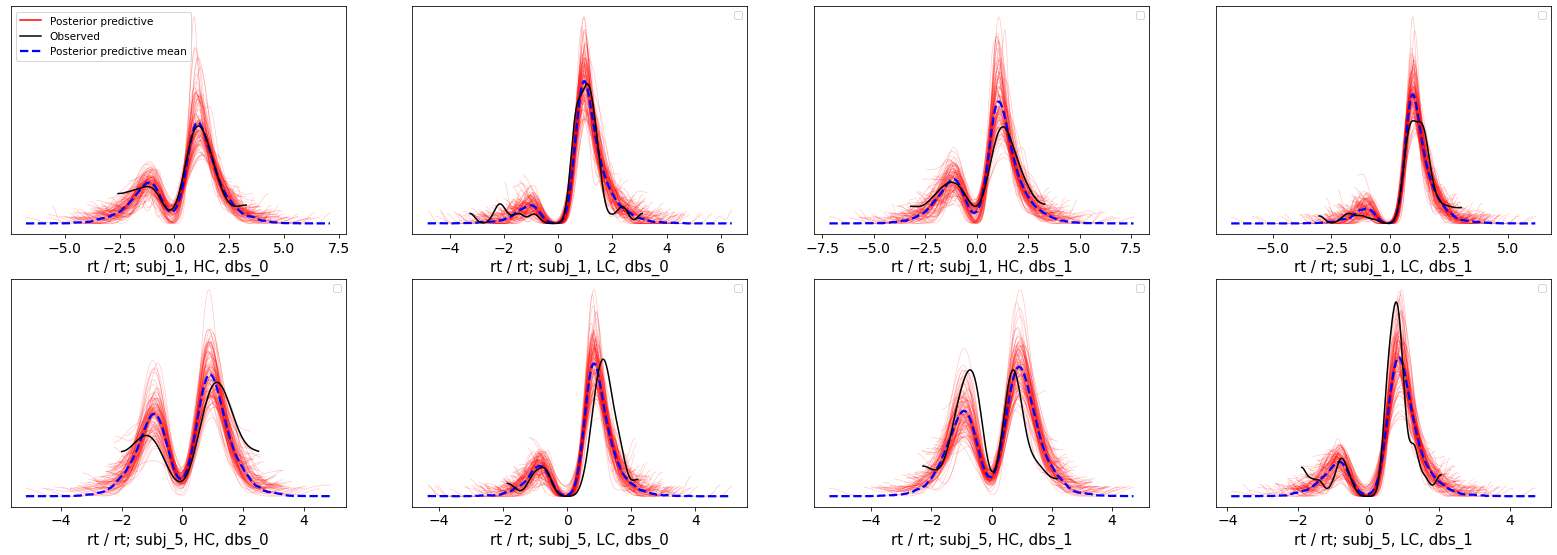

In [13]:
or_d = hddm.load_csv('/opt/conda/lib/python3.7/site-packages/hddm/examples/cavanagh_theta_nn.csv')

plot_ppc_by_cond(data = InfData['ms7'],
                 or_d = or_d,
                 subjs = [1, 5],
                 cond = {'conf': ['HC', 'LC', 'HC', 'LC'],
                         'dbs': [0, 0, 1, 1]},
                 colors = ['r', 'k', 'b'],
                 num_pp_samples=100,
                 alpha = 0.2,
                 var_names=['rt'])

In [25]:
data = InfData['ms7'] # define data
kind="kde"
alpha=0.8
mean=True
observed=True
color=None
colors=["C0", "k", "r"]
grid=None
figsize=None
textsize=None
data_pairs=None
var_names=['rt']
filter_vars=None
coords=None
flatten=None
flatten_pp=None
num_pp_samples=50
random_seed=None
jitter=None
animated=False
animation_kwargs=None
legend=True
labeller=None
ax=None
backend=None
backend_kwargs=None
group="posterior"
show=None

subjects = [6, 3]
cond = {'conf': ['HC', 'LC', 'HC', 'LC'],
        'dbs': [0, 0, 1, 1]}



In [26]:
if group not in ("posterior", "prior"):
    raise TypeError("`group` argument must be either `posterior` or `prior`")

for groups in (f"{group}_predictive", "observed_data"):
    if not hasattr(data, groups):
        raise TypeError(f'`data` argument must have the group "{groups}" for ppcplot')

if kind.lower() not in ("kde", "cumulative", "scatter"):
    raise TypeError("`kind` argument must be either `kde`, `cumulative`, or `scatter`")

if colors is None:
    colors = ["C0", "k", "C1"]

if isinstance(colors, str):
    raise TypeError("colors should be a list with 3 items.")

if len(colors) != 3:
    raise ValueError("colors should be a list with 3 items.")

if color is not None:
    warnings.warn("color has been deprecated in favor of colors", FutureWarning)
    colors[0] = color

if data_pairs is None:
    data_pairs = {}

if backend is None:
    backend = rcParams["plot.backend"]
backend = backend.lower()
if backend == "bokeh":
    if animated:
        raise TypeError("Animation option is only supported with matplotlib backend.")

observed_data = data.observed_data

if group == "posterior":
    predictive_dataset = data.posterior_predictive
elif group == "prior":
    predictive_dataset = data.prior_predictive
    
if coords is None:
    coords = {}
    
if labeller is None:
    labeller = BaseLabeller()

if random_seed is not None:
    np.random.seed(random_seed)

total_pp_samples = predictive_dataset.sizes["chain"] * predictive_dataset.sizes["draw"]
if num_pp_samples is None:
    if kind == "scatter" and not animated:
        num_pp_samples = min(5, total_pp_samples)
    else:
        num_pp_samples = total_pp_samples

if (
    not isinstance(num_pp_samples, Integral)
    or num_pp_samples < 1
    or num_pp_samples > total_pp_samples
):
    raise TypeError(
        "`num_pp_samples` must be an integer between 1 and " + f"{total_pp_samples}."
    )

pp_sample_ix = np.random.choice(total_pp_samples, size=num_pp_samples, replace=False)

for key in coords.keys():
    coords[key] = np.where(np.in1d(observed_data[key], coords[key]))[0]

In [27]:
obs_plotters = []
pp_plotters = []
for subj_idx in subjects:
    if cond is not None:
        for conf_idx, dbs_idx in zip(cond['conf'], cond['dbs']):
            plot_idx = or_d[(or_d.subj_idx == subj_idx) & (or_d.conf == conf_idx) & (or_d.dbs==dbs_idx)].index
            data_tmp = data.isel(trial_idx=plot_idx)
            
            observed_data_tmp = data_tmp.observed_data
            predictive_data_tmp = data_tmp.posterior_predictive

            if var_names is None:
                var_names = list(observed_data_tmp.data_vars)
            var_names = _var_names(var_names, observed_data_tmp, filter_vars)
            pp_var_names = [data_pairs.get(var, var) for var in var_names]
            pp_var_names = _var_names(pp_var_names, predictive_data_tmp, filter_vars)

            if flatten_pp is None and flatten is None:
                flatten_pp = list(predictive_data_tmp.dims.keys())
            elif flatten_pp is None:
                flatten_pp = flatten
            if flatten is None:
                flatten = list(observed_data_tmp.dims.keys())

            total_pp_samples = predictive_data_tmp.sizes["chain"] * predictive_data_tmp.sizes["draw"]

            pp_sample_ix = np.random.choice(total_pp_samples, size=num_pp_samples, replace=False)

            for key in coords.keys():
                coords[key] = np.where(np.in1d(observed_data_tmp[key], coords[key]))[0]

            obs_plotters_tmp = filter_plotters_list(
                list(
                    xarray_var_iter(
                        observed_data_tmp.isel(coords),
                        skip_dims=set(flatten),
                        var_names=var_names,
                        combined=True,
                    )
                ),
                "plot_ppc",
            )
            
            length_plotters_tmp = len(obs_plotters_tmp)
            pp_plotters_tmp = [
                tup
                for _, tup in zip(
                    range(length_plotters_tmp),
                    xarray_var_iter(
                        predictive_data_tmp.isel(coords),
                        var_names=pp_var_names,
                        skip_dims=set(flatten_pp),
                        combined=True,
                    ),
                )
            ]
            for ls_idx in range(len(var_names)):
                tmp0 = list(obs_plotters_tmp[0])
                tmp0[1]['subj_idx'] = "subj_" + str(subj_idx)
                tmp0[1]['conf'] = conf_idx
                tmp0[1]['dbs'] = "dbs_" + str(dbs_idx)
                tmp0[2]['subj_idx'] = "subj_" + str(subj_idx)
                tmp0[2]['conf'] = conf_idx
                tmp0[2]['dbs'] = "dbs_" + str(dbs_idx)

                tmp1 = list(pp_plotters_tmp[0])
                tmp1[1]['subj_idx'] = "subj_" + str(subj_idx)
                tmp1[1]['conf'] = conf_idx
                tmp1[1]['dbs'] = "dbs_" + str(dbs_idx)
                tmp1[2]['subj_idx'] = "subj_" + str(subj_idx)
                tmp1[2]['conf'] = conf_idx
                tmp1[2]['dbs'] = "dbs_" + str(dbs_idx)

                obs_plotters.append(tuple(tmp0))
                pp_plotters.append(tuple(tmp1))
length_plotters = len(obs_plotters)
rows, cols = default_grid(length_plotters, grid=grid)

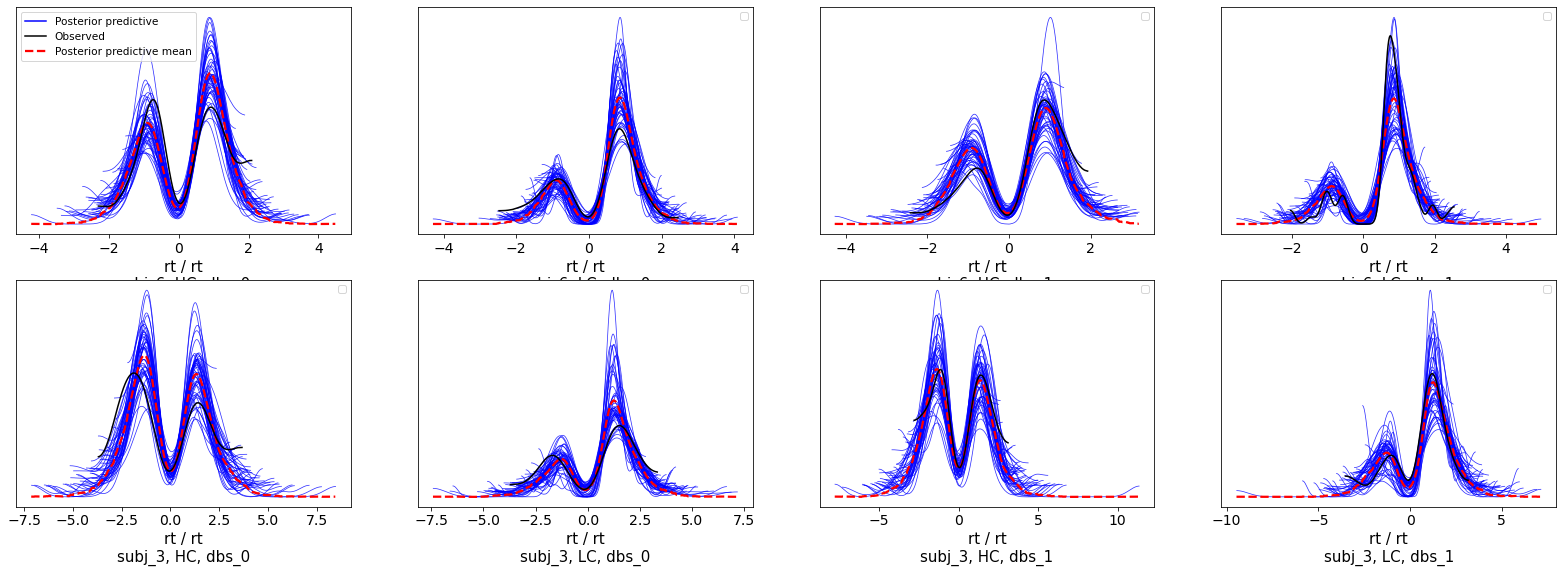

In [28]:
ppcplot_kwargs = dict(
    ax=ax,
    length_plotters=length_plotters,
    rows=rows,
    cols=cols,
    figsize=figsize,
    animated=animated,
    obs_plotters=obs_plotters,
    pp_plotters=pp_plotters,
    predictive_dataset=predictive_dataset,
    pp_sample_ix=pp_sample_ix,
    kind=kind,
    alpha=alpha,
    colors=colors,
    jitter=jitter,
    textsize=textsize,
    mean=mean,
    observed=observed,
    total_pp_samples=total_pp_samples,
    legend=legend,
    labeller=labeller,
    group=group,
    animation_kwargs=animation_kwargs,
    num_pp_samples=num_pp_samples,
    backend_kwargs=backend_kwargs,
    show=show,
)

plot = get_plotting_function("plot_ppc", "ppcplot", backend)
axes = plot(**ppcplot_kwargs)